# Comparison of all Pedersen N02 cases

## Nalu-Wind/AMR-Wind vs Pedersen (2014) results

Comparison between our runs and Pedersen's 2014 paper

**Note**: Sandians run using `canopy/2.1.9` to get all of the right libraries

In [1]:
%%capture
import sys
sys.path.insert(1, '../utilities')
import windspectra, load_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
# Provide locations and parameters of data
l_cases = {
    'amrwind-ksgs': load_data.AMRWindStats('AmrWind'),
    'naluwind-smag': load_data.NaluWindStats('NaluWindRun02'),
    'naluwind-ksgs': load_data.NaluWindStats('NaluWindRun03'),
    'Pederson:2014': load_data.PedersonData('pedersen2014_data')
    }

deltaX=3000.0/288         # Grid spacing

# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["c", "k", "b",'r']) 

## Plot velocity profiles

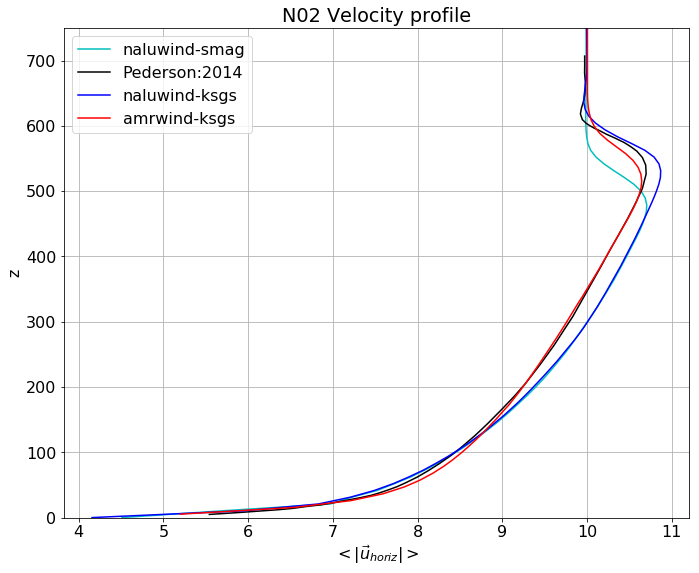

In [3]:
fig = plt.figure(figsize=(10,8))
plt.rc('font', size=16)

for l,c in l_cases.items():
    plt.plot(c.hvelmag, c.z, label=l)
plt.ylim()
plt.xlabel(r'$< | \vec{u}_{horiz} | >$')
plt.ylabel('z')
plt.legend(loc=0)
plt.ylim(0,750)
plt.grid()
plt.tight_layout()
plt.title('N02 Velocity profile')


## Plot temperature

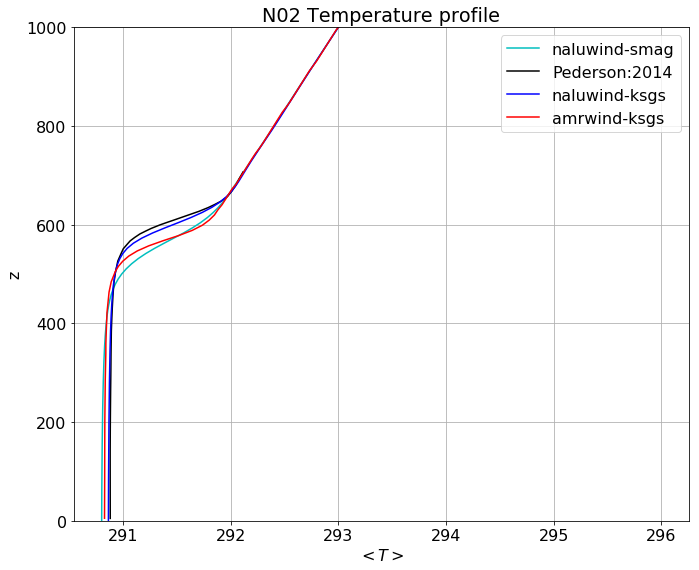

In [4]:
fig = plt.figure(figsize=(10,8))
plt.rc('font', size=16)

for l,c in l_cases.items():
    plt.plot(c.T, c.z, label=l)
plt.xlabel(r'$<T>$')
plt.ylabel('z')
plt.legend(loc=0)
plt.ylim(0,1000)
plt.grid()
plt.tight_layout()
plt.title('N02 Temperature profile')

## Plot Spectra

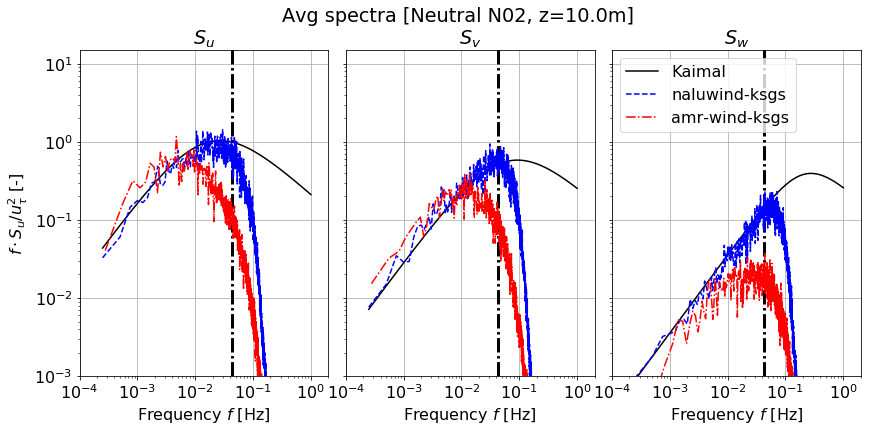

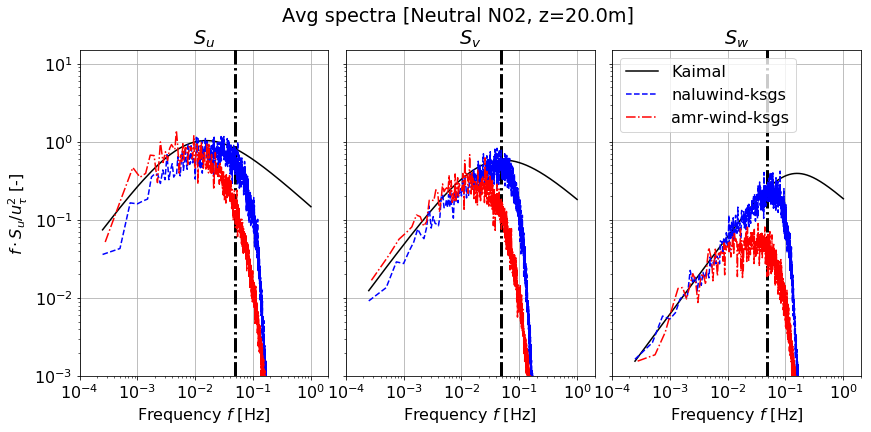

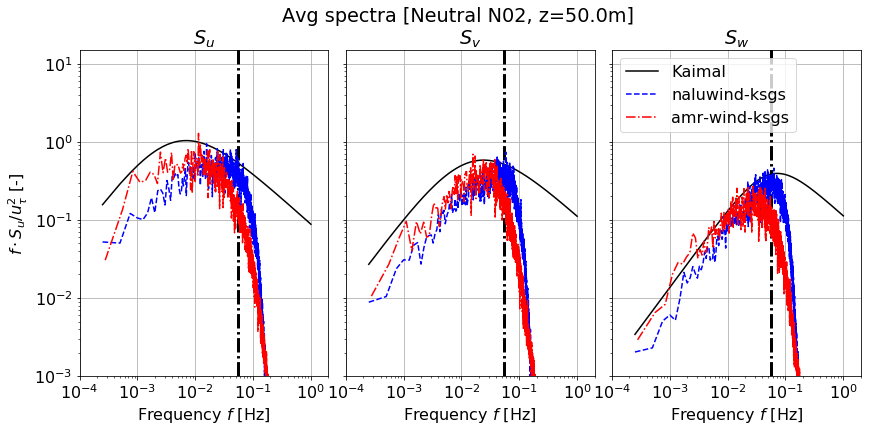

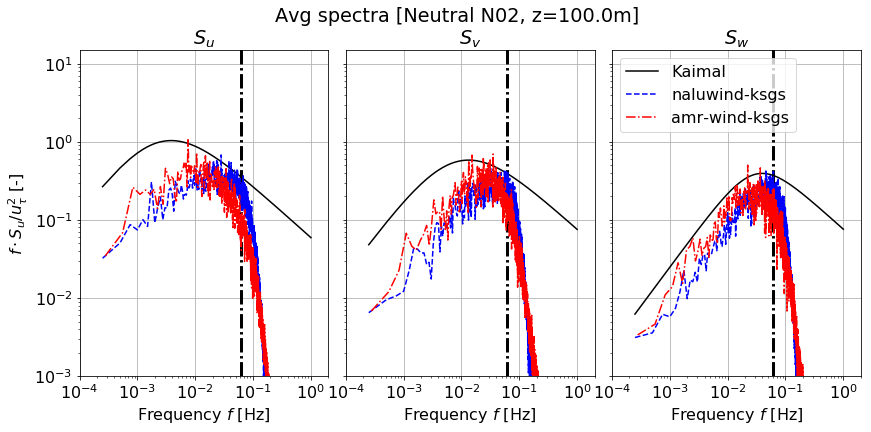

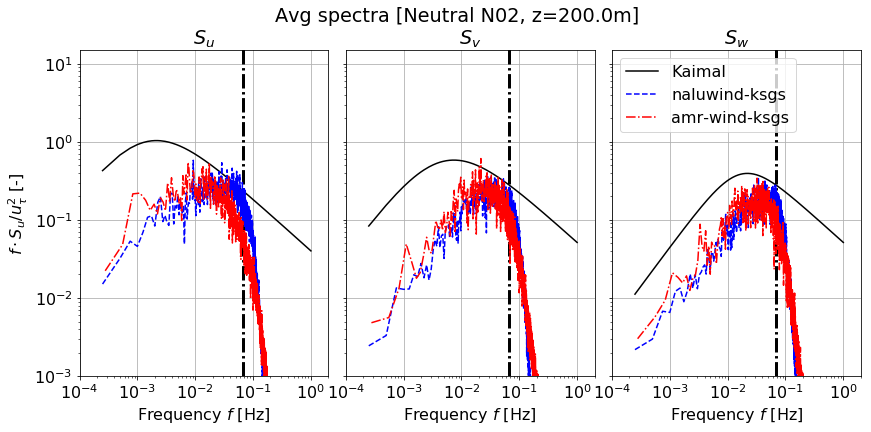

In [5]:
for i, z in enumerate(l_cases['naluwind-ksgs'].ps_data['z']):
    f, suu, svv, sww = l_cases['naluwind-ksgs'].point_spectra(z)
    utau = l_cases['naluwind-ksgs'].istats['ustar']
    hvelmag = l_cases['naluwind-ksgs'].interp_hvelmag(z)
    f_a, suu_a, svv_a, sww_a = l_cases['amrwind-ksgs'].point_spectra(z)
    utau_a = float(l_cases['amrwind-ksgs'].istats['ustar'])
    fmax = 0.6*hvelmag/(8*deltaX)
    
    fig, axs = plt.subplots(1,3,figsize=(14,6),sharey=True)
    # Plot Suu spectra
    lineu, = axs[0].loglog(f, windspectra.getKaimal(f, z, hvelmag ),label='Kaimal - u', color='k')
    axs[0].loglog(f, f * suu/(utau * utau) , '--', color='b',label='naluwind-ksgs - u')
    axs[0].loglog(f_a, f_a * suu_a/(utau_a * utau_a),  '-.', color='r', label='amr-wind-ksgs - u')
    axs[0].vlines(fmax, 5e-4, 20,lw=3, linestyle='-.')
    axs[0].set_xlim(1e-4,2)
    axs[0].set_ylim(1e-3,15)
    axs[0].grid()
    axs[0].set_xlabel('Frequency $f$ [Hz]')
    axs[0].set_ylabel('$f\cdot S_{u}/u_{\\tau}^2$ [-]')
    axs[0].set_title('$S_{u}$')

    # Plot Svv spectra
    linev, = axs[1].loglog(f, windspectra.getKaimal(f, z, hvelmag, params=windspectra.vKaimalconst),label='Kaimal - v', color='k')
    axs[1].loglog(f, f * svv/(utau * utau) , '--', color='b', label='naluwind-ksgs - v')
    axs[1].loglog(f_a, f_a * svv_a/(utau_a * utau_a) , '-.', color='r', label='amr-wind-ksgs - v')
    axs[1].vlines(fmax, 5e-4, 20,lw=3, linestyle='-.')
    axs[1].set_xlim(1e-4,2)
    axs[1].set_ylim(1e-3,15)
    axs[1].grid()
    axs[1].set_xlabel('Frequency $f$ [Hz]')
    axs[1].set_title('$S_{v}$')
    
    # Plot Sww spectra
    linew, = axs[2].loglog(f, windspectra.getKaimal(f, z, hvelmag, params=windspectra.wKaimalconst),label='Kaimal', color='k')
    axs[2].loglog(f, f * sww/(utau * utau) , '--', color='b', label='naluwind-ksgs')
    axs[2].loglog(f_a, f_a * sww_a/(utau_a * utau_a) , '-.', color='r',  label='amr-wind-ksgs')
    axs[2].vlines(fmax, 5e-4, 20,lw=3, linestyle='-.')
    axs[2].set_xlim(1e-4,2)
    axs[2].set_ylim(1e-3,15)
    axs[2].grid()
    axs[2].set_xlabel('Frequency $f$ [Hz]')
    axs[2].set_title('$S_{w}$')
    axs[2].legend(loc='upper left')

    
    fig.suptitle('Avg spectra [Neutral N02, z={:.1f}m]'.format(z))
    plt.subplots_adjust(wspace=0.07)